# LSTM Cell Implementation from Scratch

## Introduction

Long Short-Term Memory (LSTM) networks are a specialized type of Recurrent Neural Network (RNN) designed to learn long-term dependencies in sequential data. Introduced by Hochreiter and Schmidhuber in 1997, LSTMs address the vanishing gradient problem that plagues standard RNNs.

## Mathematical Foundation

### The LSTM Cell Architecture

An LSTM cell maintains two state vectors:
- **Cell state** $\mathbf{c}_t$: The long-term memory
- **Hidden state** $\mathbf{h}_t$: The short-term memory (output)

The cell uses three gates to control information flow:

### 1. Forget Gate

The forget gate decides what information to discard from the cell state:

$$\mathbf{f}_t = \sigma(\mathbf{W}_f \cdot [\mathbf{h}_{t-1}, \mathbf{x}_t] + \mathbf{b}_f)$$

where $\sigma$ is the sigmoid function, $\mathbf{W}_f$ is the weight matrix, $\mathbf{h}_{t-1}$ is the previous hidden state, $\mathbf{x}_t$ is the current input, and $\mathbf{b}_f$ is the bias.

### 2. Input Gate

The input gate controls what new information to store:

$$\mathbf{i}_t = \sigma(\mathbf{W}_i \cdot [\mathbf{h}_{t-1}, \mathbf{x}_t] + \mathbf{b}_i)$$

A candidate cell state is computed:

$$\tilde{\mathbf{c}}_t = \tanh(\mathbf{W}_c \cdot [\mathbf{h}_{t-1}, \mathbf{x}_t] + \mathbf{b}_c)$$

### 3. Cell State Update

The cell state is updated by forgetting old information and adding new:

$$\mathbf{c}_t = \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \tilde{\mathbf{c}}_t$$

where $\odot$ denotes element-wise multiplication (Hadamard product).

### 4. Output Gate

The output gate determines the hidden state output:

$$\mathbf{o}_t = \sigma(\mathbf{W}_o \cdot [\mathbf{h}_{t-1}, \mathbf{x}_t] + \mathbf{b}_o)$$

$$\mathbf{h}_t = \mathbf{o}_t \odot \tanh(\mathbf{c}_t)$$

## Parameter Dimensions

For input dimension $d$ and hidden dimension $n$:
- Weight matrices: $\mathbf{W}_f, \mathbf{W}_i, \mathbf{W}_c, \mathbf{W}_o \in \mathbb{R}^{n \times (n+d)}$
- Bias vectors: $\mathbf{b}_f, \mathbf{b}_i, \mathbf{b}_c, \mathbf{b}_o \in \mathbb{R}^n$
- Total parameters: $4n(n+d) + 4n = 4n(n+d+1)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## Implementation

### Activation Functions

In [2]:
def sigmoid(x):
    """Sigmoid activation function.
    
    σ(x) = 1 / (1 + exp(-x))
    
    Clips input to prevent overflow.
    """
    x = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x))

def tanh(x):
    """Hyperbolic tangent activation function."""
    return np.tanh(x)

### LSTM Cell Class

In [3]:
class LSTMCell:
    """Long Short-Term Memory Cell.
    
    Parameters
    ----------
    input_dim : int
        Dimension of input vector
    hidden_dim : int
        Dimension of hidden state
    """
    
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Xavier/Glorot initialization for better gradient flow
        scale = np.sqrt(2.0 / (input_dim + hidden_dim))
        concat_dim = input_dim + hidden_dim
        
        # Forget gate parameters
        self.W_f = np.random.randn(hidden_dim, concat_dim) * scale
        self.b_f = np.ones(hidden_dim)  # Initialize to 1 for better gradient flow
        
        # Input gate parameters
        self.W_i = np.random.randn(hidden_dim, concat_dim) * scale
        self.b_i = np.zeros(hidden_dim)
        
        # Candidate cell state parameters
        self.W_c = np.random.randn(hidden_dim, concat_dim) * scale
        self.b_c = np.zeros(hidden_dim)
        
        # Output gate parameters
        self.W_o = np.random.randn(hidden_dim, concat_dim) * scale
        self.b_o = np.zeros(hidden_dim)
        
        # Cache for storing intermediate values (useful for backprop)
        self.cache = {}
    
    def forward(self, x_t, h_prev, c_prev):
        """Forward pass of LSTM cell.
        
        Parameters
        ----------
        x_t : ndarray, shape (input_dim,)
            Input at time t
        h_prev : ndarray, shape (hidden_dim,)
            Hidden state at time t-1
        c_prev : ndarray, shape (hidden_dim,)
            Cell state at time t-1
            
        Returns
        -------
        h_t : ndarray, shape (hidden_dim,)
            Hidden state at time t
        c_t : ndarray, shape (hidden_dim,)
            Cell state at time t
        """
        # Concatenate previous hidden state and current input
        concat = np.concatenate([h_prev, x_t])
        
        # Forget gate
        f_t = sigmoid(np.dot(self.W_f, concat) + self.b_f)
        
        # Input gate
        i_t = sigmoid(np.dot(self.W_i, concat) + self.b_i)
        
        # Candidate cell state
        c_tilde = tanh(np.dot(self.W_c, concat) + self.b_c)
        
        # Update cell state
        c_t = f_t * c_prev + i_t * c_tilde
        
        # Output gate
        o_t = sigmoid(np.dot(self.W_o, concat) + self.b_o)
        
        # Hidden state
        h_t = o_t * tanh(c_t)
        
        # Store intermediate values for visualization
        self.cache = {
            'f_t': f_t,
            'i_t': i_t,
            'o_t': o_t,
            'c_tilde': c_tilde,
            'c_t': c_t,
            'h_t': h_t
        }
        
        return h_t, c_t
    
    def forward_sequence(self, X):
        """Process a sequence of inputs.
        
        Parameters
        ----------
        X : ndarray, shape (seq_len, input_dim)
            Input sequence
            
        Returns
        -------
        H : ndarray, shape (seq_len, hidden_dim)
            Hidden states for all time steps
        C : ndarray, shape (seq_len, hidden_dim)
            Cell states for all time steps
        gates : dict
            Gate activations for all time steps
        """
        seq_len = X.shape[0]
        
        # Initialize states
        h_t = np.zeros(self.hidden_dim)
        c_t = np.zeros(self.hidden_dim)
        
        # Storage for outputs
        H = np.zeros((seq_len, self.hidden_dim))
        C = np.zeros((seq_len, self.hidden_dim))
        gates = {'f': [], 'i': [], 'o': [], 'c_tilde': []}
        
        for t in range(seq_len):
            h_t, c_t = self.forward(X[t], h_t, c_t)
            H[t] = h_t
            C[t] = c_t
            
            # Store gate activations
            gates['f'].append(self.cache['f_t'].copy())
            gates['i'].append(self.cache['i_t'].copy())
            gates['o'].append(self.cache['o_t'].copy())
            gates['c_tilde'].append(self.cache['c_tilde'].copy())
        
        # Convert to arrays
        for key in gates:
            gates[key] = np.array(gates[key])
        
        return H, C, gates

## Demonstration

### Generate Synthetic Sequence Data

We'll create a simple sinusoidal signal to demonstrate the LSTM's ability to process sequential data.

In [4]:
# Generate synthetic sequence data
seq_len = 50
input_dim = 3
hidden_dim = 8

# Create time-varying input signals
t = np.linspace(0, 4 * np.pi, seq_len)
X = np.zeros((seq_len, input_dim))
X[:, 0] = np.sin(t)                    # Sine wave
X[:, 1] = np.cos(t)                    # Cosine wave
X[:, 2] = np.sin(2 * t) * 0.5          # Higher frequency component

print(f"Input sequence shape: {X.shape}")
print(f"Input dimension: {input_dim}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Sequence length: {seq_len}")

Input sequence shape: (50, 3)
Input dimension: 3
Hidden dimension: 8
Sequence length: 50


### Initialize and Run LSTM Cell

In [5]:
# Create LSTM cell
lstm = LSTMCell(input_dim, hidden_dim)

# Process the sequence
H, C, gates = lstm.forward_sequence(X)

print(f"\nOutput shapes:")
print(f"Hidden states H: {H.shape}")
print(f"Cell states C: {C.shape}")
print(f"\nTotal parameters: {4 * hidden_dim * (hidden_dim + input_dim + 1)}")


Output shapes:
Hidden states H: (50, 8)
Cell states C: (50, 8)

Total parameters: 384


## Visualization

### Gate Activations and State Evolution

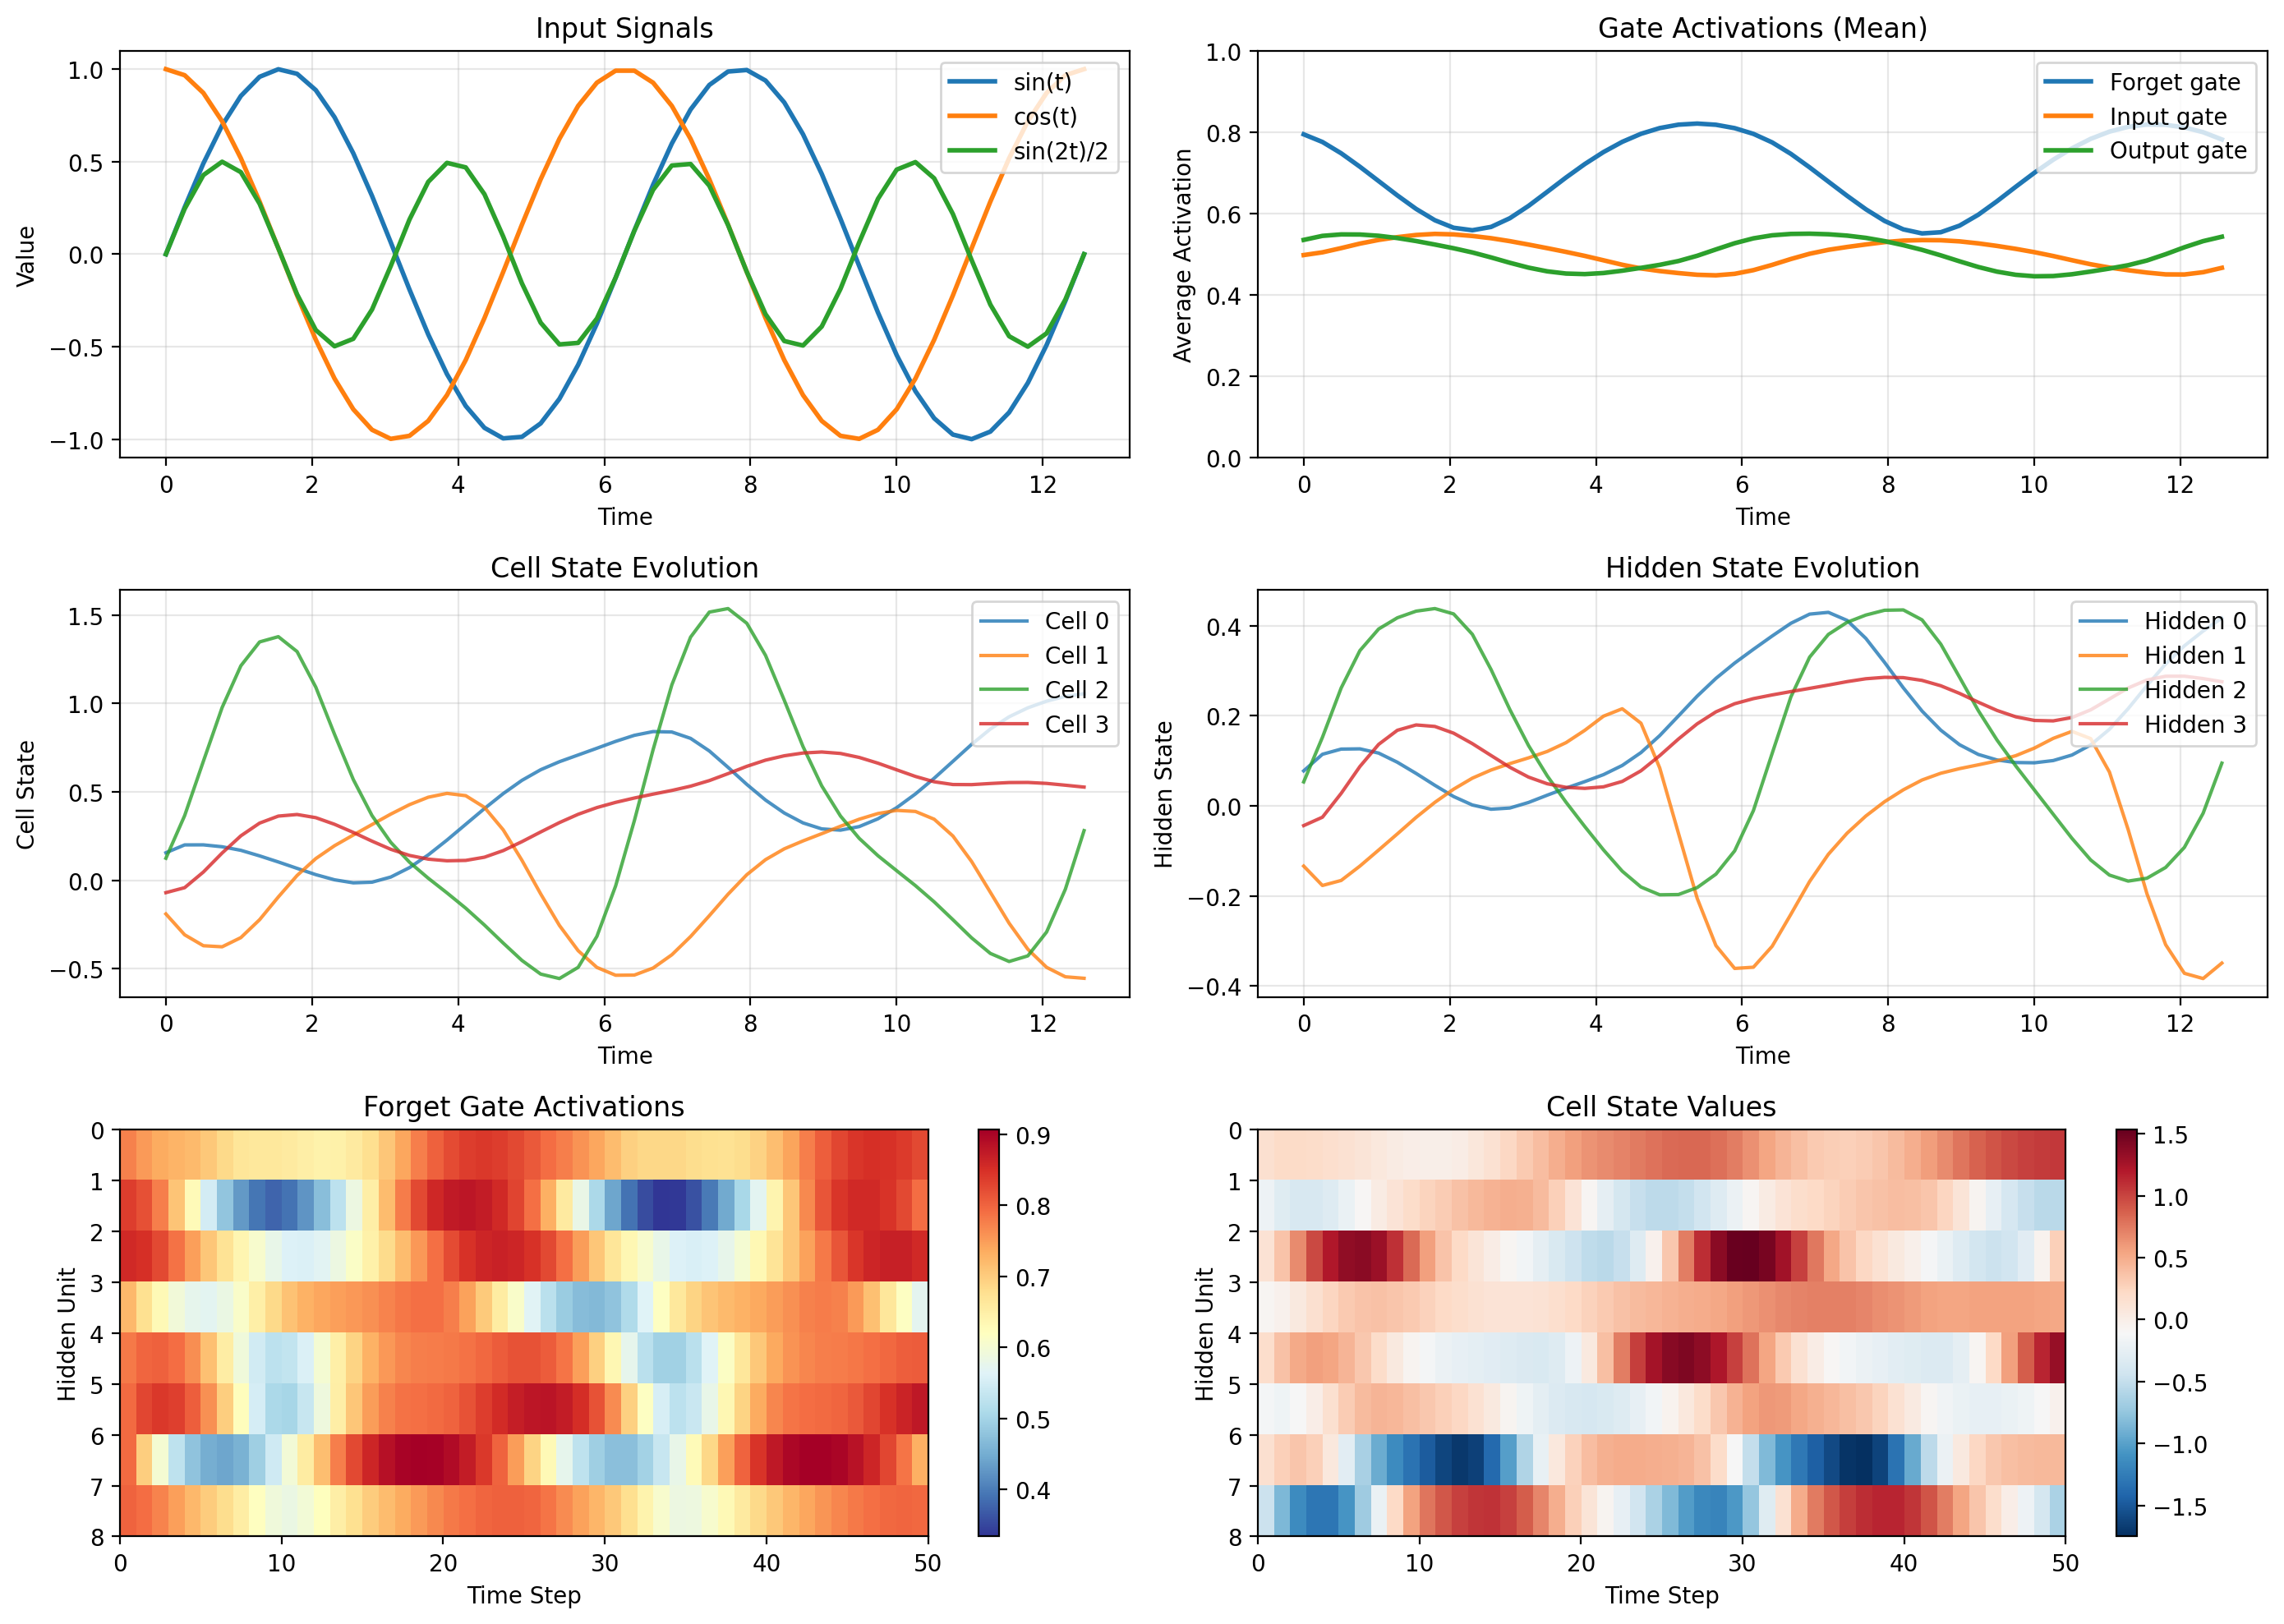


Visualization saved to 'plot.png'


In [6]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Plot 1: Input signals
ax = axes[0, 0]
ax.plot(t, X[:, 0], label='sin(t)', linewidth=2)
ax.plot(t, X[:, 1], label='cos(t)', linewidth=2)
ax.plot(t, X[:, 2], label='sin(2t)/2', linewidth=2)
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Input Signals')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Plot 2: Gate activations (averaged across hidden units)
ax = axes[0, 1]
ax.plot(t, gates['f'].mean(axis=1), label='Forget gate', linewidth=2)
ax.plot(t, gates['i'].mean(axis=1), label='Input gate', linewidth=2)
ax.plot(t, gates['o'].mean(axis=1), label='Output gate', linewidth=2)
ax.set_xlabel('Time')
ax.set_ylabel('Average Activation')
ax.set_title('Gate Activations (Mean)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Plot 3: Cell state evolution
ax = axes[1, 0]
for i in range(min(4, hidden_dim)):
    ax.plot(t, C[:, i], label=f'Cell {i}', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Cell State')
ax.set_title('Cell State Evolution')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Plot 4: Hidden state evolution
ax = axes[1, 1]
for i in range(min(4, hidden_dim)):
    ax.plot(t, H[:, i], label=f'Hidden {i}', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Hidden State')
ax.set_title('Hidden State Evolution')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Plot 5: Forget gate heatmap
ax = axes[2, 0]
im = ax.imshow(gates['f'].T, aspect='auto', cmap='RdYlBu_r', 
               extent=[0, seq_len, hidden_dim, 0])
ax.set_xlabel('Time Step')
ax.set_ylabel('Hidden Unit')
ax.set_title('Forget Gate Activations')
plt.colorbar(im, ax=ax)

# Plot 6: Cell state heatmap
ax = axes[2, 1]
im = ax.imshow(C.T, aspect='auto', cmap='RdBu_r',
               extent=[0, seq_len, hidden_dim, 0])
ax.set_xlabel('Time Step')
ax.set_ylabel('Hidden Unit')
ax.set_title('Cell State Values')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('lstm_cell_implementation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'plot.png'")

## Analysis

### Examining Gate Dynamics

In [7]:
# Compute statistics
print("Gate Activation Statistics:")
print("=" * 40)
print(f"Forget gate - Mean: {gates['f'].mean():.3f}, Std: {gates['f'].std():.3f}")
print(f"Input gate  - Mean: {gates['i'].mean():.3f}, Std: {gates['i'].std():.3f}")
print(f"Output gate - Mean: {gates['o'].mean():.3f}, Std: {gates['o'].std():.3f}")

print("\nState Statistics:")
print("=" * 40)
print(f"Cell state   - Mean: {C.mean():.3f}, Std: {C.std():.3f}")
print(f"Hidden state - Mean: {H.mean():.3f}, Std: {H.std():.3f}")

# Correlation between input and hidden state
correlations = []
for i in range(input_dim):
    for j in range(hidden_dim):
        corr = np.corrcoef(X[:, i], H[:, j])[0, 1]
        correlations.append((i, j, corr))

# Find strongest correlations
correlations.sort(key=lambda x: abs(x[2]), reverse=True)
print("\nStrongest Input-Hidden Correlations:")
print("=" * 40)
for i, j, corr in correlations[:5]:
    print(f"Input {i} <-> Hidden {j}: {corr:.3f}")

Gate Activation Statistics:
Forget gate - Mean: 0.704, Std: 0.124
Input gate  - Mean: 0.499, Std: 0.112
Output gate - Mean: 0.501, Std: 0.117

State Statistics:
Cell state   - Mean: 0.153, Std: 0.608
Hidden state - Mean: 0.062, Std: 0.245

Strongest Input-Hidden Correlations:
Input 0 <-> Hidden 2: 0.981
Input 1 <-> Hidden 6: 0.921
Input 1 <-> Hidden 1: -0.876
Input 1 <-> Hidden 7: -0.836
Input 0 <-> Hidden 5: 0.832


## Key Insights

1. **Gate Dynamics**: The gates learn to modulate information flow based on the input patterns. The forget gate typically maintains high values (~0.5-1.0) to preserve long-term information.

2. **Cell State**: Acts as a memory highway, accumulating relevant information over time. Values can grow unbounded (unlike hidden states which are squashed by tanh).

3. **Hidden State**: Represents the filtered output, bounded between -1 and 1 due to the tanh activation.

4. **Parameter Efficiency**: With $d=3$ and $n=8$, we have $4 \times 8 \times (8+3+1) = 384$ parameters - relatively few for capturing temporal dynamics.

## References

1. Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. *Neural Computation*, 9(8), 1735-1780.

2. Gers, F. A., Schmidhuber, J., & Cummins, F. (2000). Learning to Forget: Continual Prediction with LSTM. *Neural Computation*, 12(10), 2451-2471.

3. Greff, K., et al. (2017). LSTM: A Search Space Odyssey. *IEEE Transactions on Neural Networks and Learning Systems*, 28(10), 2222-2232.